# CIFAR10: Image Synthesis with GANs

|Name|Class|Admin Number|
|:----:|:----:|:----:|
|Fitri|DAAA/FT/2B/06|2222811|
|Ernest|DAAA/FT/2B/06|2222668|



<h5><b> Project Objective </b></h5>
In this project, we will be using the CIFAR10 dataset to create 1000 small colour images through researching and implementing existing GAN architecture and methods to generate new images. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Through online research, we found out that the dataset: 

<br>
<center>

<br>

>  "is a subset of the tiny images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class."
</center>

Therefore, we shall perform checks such that we acquire these values from the dataset during our Exploratory Data Analysis.
<hr>

## 1. Project Setup

### 1.1 Importing Packages and CIFAR-10

In [6]:
#General packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.notebook import tqdm
from IPython.display import clear_output, HTML

#Keras and TensorFlow
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
import visualkeras
from tensorflow.keras.datasets import cifar10
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

from keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D


import glob


c:\Users\Fitri\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Fitri\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

### 1.2 Checking CIFAR-10 Dataset

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
n_labels = len(np.unique(y_test))

print(f'Train image shape: {x_train.shape}')
print(f'Test image shape: {y_train.shape}')
print(f'Number of labels: {n_labels}')

170498071/170498071 [==============================] - 633s 4us/step
Train image shape: (50000, 32, 32, 3)
Test image shape: (50000, 1)
Number of labels: 10


## 2. Exploratory Data Analysis

### 2.1 Inspecting Images

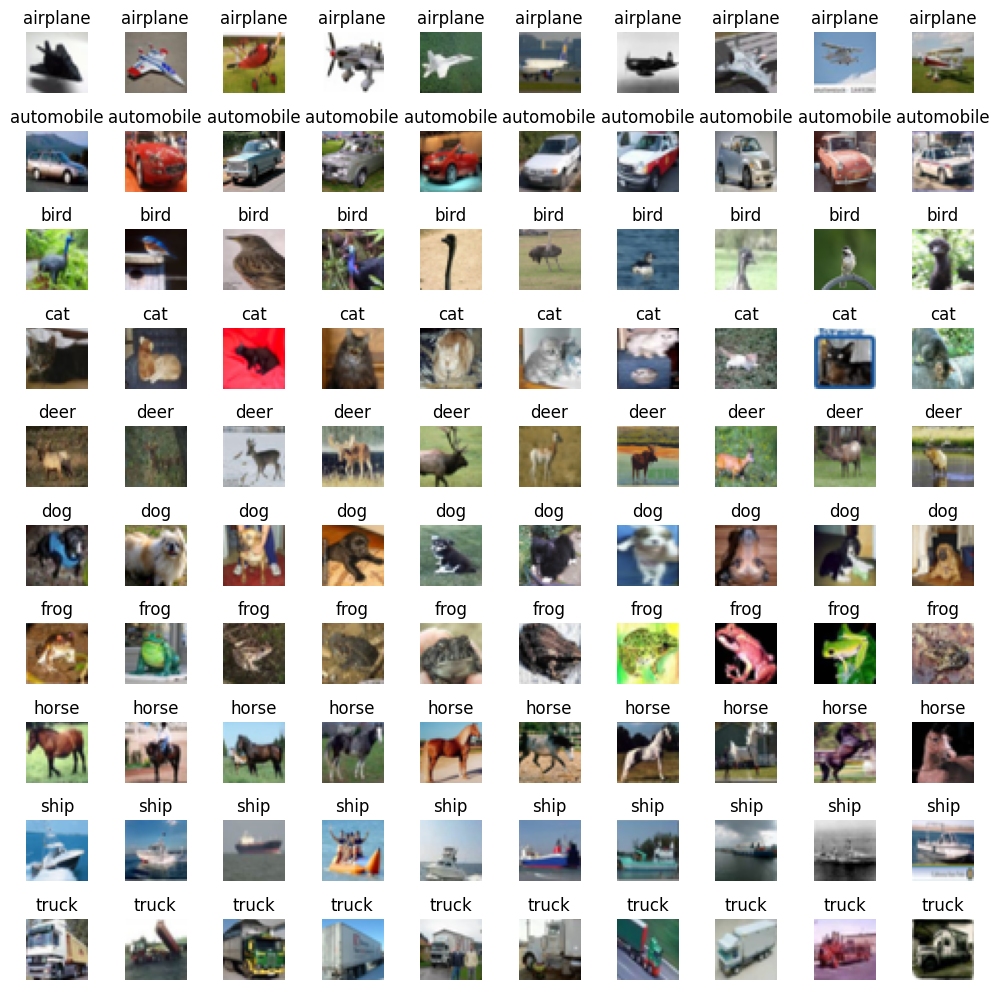

In [12]:
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

def display_images(images, labels, n_images=10):
    fig, axes = plt.subplots(nrows=n_labels, ncols=n_images, figsize=(10, 10))
    for i in range(n_images):
        for j in range(n_labels):
            axes[j, i].imshow(images[labels.flatten() == j][i])
            axes[j, i].set_title(label_map[j])
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(x_train, y_train)

__Observations:__
- One thing to note from our images is the scaling of different images due to them being all the same 32x32 image size. With cats and dogs being a good example. Where on the 9th image for the cat class, there is a text border on the image of the class. and looking at the dog class, we can only see that head of the dog is in the picture.

### 2.2 Image Averaging
If the images of a certain class are very similar, the average image will look clearer. This is because it contains the same image, and when positioned similarly, the average pixels would be concentrated in the same area for an object. Hence, we shall check the average image of all the classes.

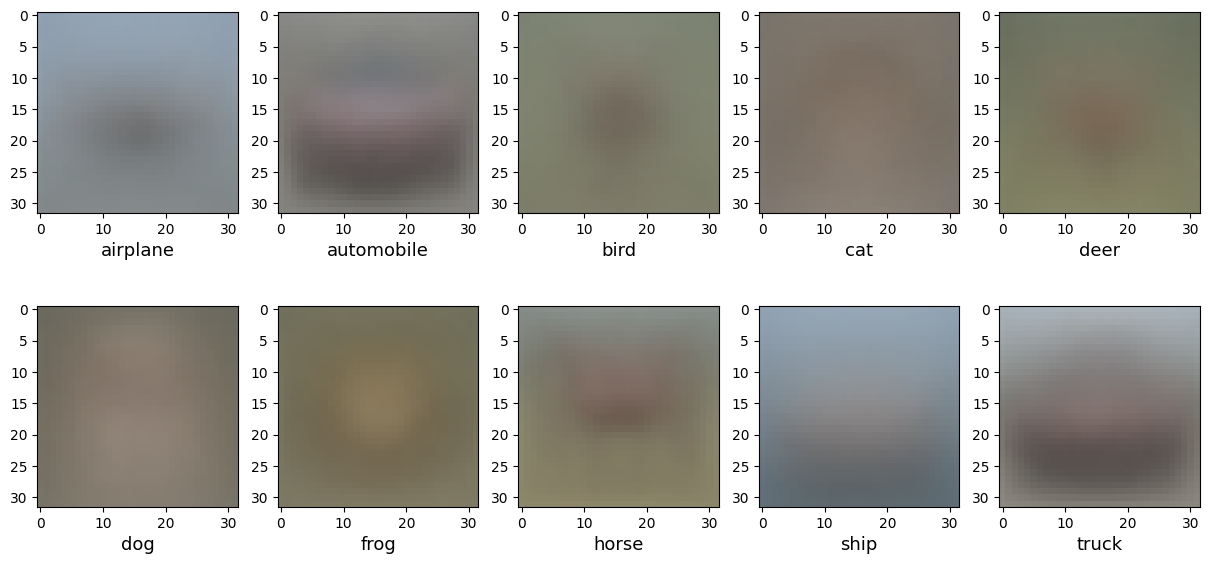

In [5]:
plt.figure(figsize=(15,7))
for i in range(len(label_map)):
    plt.subplot(2,5,i+1)
    mask = (y_train == i).reshape(50000,)
    plt.imshow(np.mean(x_train[mask] / 255, axis=0))
    plt.xlabel(label_map[i], fontsize=13)
plt.show()


__Observations:__
- Some categories like cars and horses show less variety. Even though the average images are a bit blurry, you can still make out cars, horses, and trucks. But for other categories, it's harder to see the average image. This may suggest that generated images for these categories might capture stronger and more accurate features from the training data, making them better than other classes.

### 2.3 Checking Class Distributions

In [6]:
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{label_map[label]}: {count}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


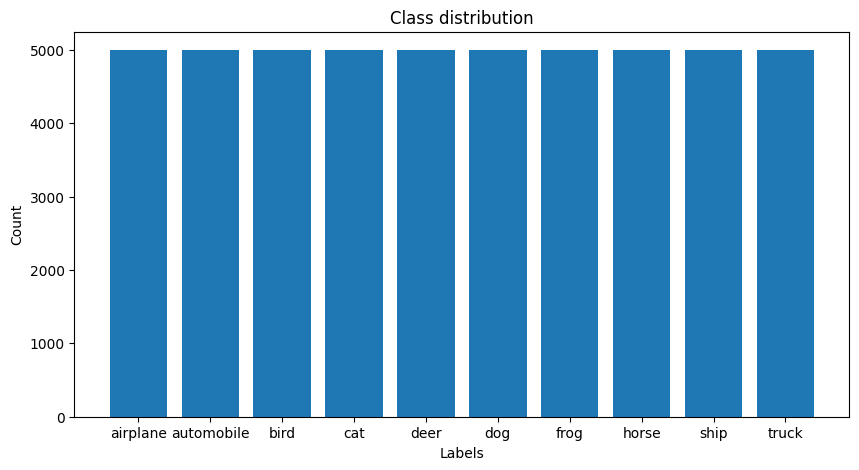

In [7]:
plt.figure(figsize=(10,5))
plt.bar(labels, counts)
plt.xticks(labels, [label_map[label] for label in labels])
plt.title('Class distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show() 

__Observations:__
- We can see that there are no class imbalances in our dataset, thus we do not need to use strategies to combat class imbalances

## 3. Data Preprocessing

### 3.1 One Hot Encoding
As currently our labels are encoded from 0-10, we will one hot encode the labels.

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(f'Label: {y_train[0]}')

Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 3.2 Normalizing
By normalizing, we adjust the pixel values of our images to be between 0 and 1. This uniformity helps our models learn faster and perform better. To do this, we calculate the mean and standard deviation of the training data and use a formula to modify each input accordingly:
$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

In [9]:
preprocessing = Normalization()
preprocessing.adapt(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


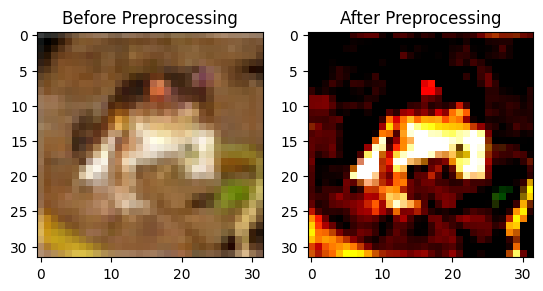

In [10]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(x_train[0])
ax[0].set_title('Before Preprocessing')
ax[1].imshow(tf.squeeze(preprocessing(x_train[:1, :, :])))
ax[1].set_title('After Preprocessing')
plt.show()

In [11]:
x_train = x_train.astype('float32')
x_train /= (255/2)
x_train -= 1

### 3.3 Data Augmentation
Data augmentation is a widely used technique in deep learning to mitigate overfitting by introducing random transformations to images, thereby creating diverse variations. In our project, the aim is to address overfitting in the discriminator. The presence of an overfitted discriminator, as highlighted in Karras et al.'s paper "Training Generative Adversarial Networks with Limited Data,"[[1]](https://arxiv.org/abs/2006.06676) can result in a deterioration of the generated image quality.

However, a drawback from using data augmentation on training GANs is that it could mislead the generator to learn the distribution of the augmented data, which could be different from that of the original data. As mentioned in the paper "On Data Augmentation for GAN Training" by Ngoc-Trung Tran [[2]](https://arxiv.org/pdf/2006.05338.pdf).
> "Some transformed data could be infrequent or non-existence w.r.t. the original data distribution (Pd(T(x)) ≈ 0, where T(x) is some transformed data by a transformation T). On the other hand, augmenting the dataset may mislead the generator to learn to generate these transformed data. For example, if rotation is used for data augmentation on a dataset with category “horses”, the generator may learn to create rotated horses, which could be inappropriate in some applications."

Thus we will avoid the use of Data Augmentation for now.

# 4. Models

#### We will be comparing these models
- DCGAN (Baseline)
- ACGAN
- CGAN
## First of all what is a GAN?
<img src="./images/components_of_GAN.jfif" alt="" style="width: 60%;"/>

[[Source]](https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/)

A Generative Adversarial Network (GAN) consists of 2 models. A Generator and a discriminator. Both of them are competing against each other. The goal of the generator is to make a fake image to fool the discrimintor into thinking that the image is real. While the discriminator's goal is to correctly pick the real and fake images apart from each other. With both of them trying to one up another, they compete adversarially in a game and continously try to beat each other.

$$\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]$$

__Generator__

The generator takes in random noise as input and tries to converts them into a realistic representation of a image to fool the discriminator. The ultimate goal is to create outputs realistic enough to deceive the Discriminator into classifying them as genuine images. Through training, the generator improves its ability to generate more diverse and authentic-looking data, engaging in a continual zero sum game with the Discriminator

__Discriminator__

The Discriminator tries to distingush between real and fake images. It processes both genuine and fake samples, aiming to accurately identify the source of each. Through training, the Discriminator updates its parameters based on its ability to discriminate between real and generated data,thus providing feedback to the Generator, guiding its improvement.

### GAN training process [[3]](https://developers.google.com/machine-learning/gan/gan_structure)
If there are 2 models competing and training together, how do we excalty train our GAN? There are multiple steps to take when training for a GAN.

__1. Discriminator__
- It classifies both real data and fake data from the generator.
- Then the discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.
- Finally the discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

<img src="./images/gan_diagram_discriminator.svg" alt="" style="width: 60%;"/>

[[Source]](https://developers.google.com/machine-learning/gan/discriminator)

__2. Generator__
- Get some Sample random noise.
- Then produce generator output from sampled random noise.
- Get discriminator "Real" or "Fake" classification for generator output.
- Next calculate loss from discriminator classification.
- Backpropagate through both the discriminator and generator to obtain gradients.
- Lastly use gradients to change only the generator weights.

<img src="./images/gan_diagram_generator.svg" alt="" style="width: 60%;"/>

[[Source]](https://developers.google.com/machine-learning/gan/generator)

We repeat the discriminator and generator steps in order to continue training the GAN network.

### How do we evaluate our models?
- Inception Score
- Frechet Inception Distance

### What do we need to keep in mind?
- Model collapse
- GAN failure modes
### Parameters (Batch Size)

## 4.1 Baseline Model

Firstly,we had to find a method to decide on a baseline model. Based on a documentation by Pytorch, a DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. From that paper, we learn that the discriminator are made out of a few layers/activation methods, namely strided convolution layers, batch norm layers, and LeakyReLU activations. The paper states that there are multiple guidelines for stable DCGANs.

> Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator). <br>

- This allows the network to learn its own spatial downsampling

> Use batchnorm in both the generator and the discriminator.<br>

- To quote from the first paper on DCGANs, this is how it helped the network perform better generally: 

"
[Batchnorm] stabilizes learning by normalizing the
input to each unit to have zero mean and unit variance. This helps deal with training problems that
arise due to poor initialization and helps gradient flow in deeper models. This proved critical to get
deep generators to begin learning, preventing the generator from collapsing all samples to a single
point which is a common failure mode observed in GANs
"

> Remove fully connected hidden layers for deeper architectures. <br>



> Use ReLU activation in generator for all layers except for the output, which uses Tanh.<br>



> Use LeakyReLU activation in the discriminator for all layers.<br>

- It is used in the generator as it is a bounding activation function. This allows the network to learn more quickly to saturate and cover the color space of the training distribution. According to the paper, it helped with higher resolution modeling.

From these requirements, we now know what to look out for when creating the network, as well as how it works. DCGANs are simple, and not tuned to specific scenarios. Hence, they would be perfect in this scenario to generalise the outputs of the network, yet better than regular GANs as DCGANs already have a premade architecture guideline (as stated above).

### Utility Functions

In [11]:
from tensorflow.keras.layers import Embedding

# With reference to https://github.com/bioinf-jku/TTUR for the FID as well as IS scores

'''
These are some functions needed:
- Save loss and accuracy of training for a specified model
- Calculations for the metrics
- Generating images from the generator 
'''



def generate_images(generator, noise, label_number, label_names):
    # Create a random noise vector

    noise_vector = tf.random.normal

def load_generator_model(model_filepath):
    return keras.models.load_model(model_filepath)


## Used for generating images for a single class. More for conditional GANs
def gen100Images(generator, class_number, latent_dims = 100, label_names = label_names):
    '''
        For the main image generation, we will need to:
        - Create a random noise vector
        For this, we will need to use latent dimensions. This is the number of dimensions that the noise vector will have.
        - Create 100 labels for a single class
        - Use generator to predict noise vs class
        - Reshape the output to [0,255] 
        - Plot the image
    '''
    random_latent_vectors = tf.random.normal(shape=(100, latent_dims))

    class_labels = np.repeat(class_number, 100)

    '''
    In Keras, a model can have multiple inputs, and when there are multiple inputs, they are typically provided as a list.
    If the generator takes a list of inputs, it assumes that the generator expects both random noise vectors (random_latent_vectors) 
    and class labels (class_labels) as input.
    If it's not a list, it means the generator expects only random noise vectors.
    '''
    if isinstance(generator.input, list):
        input_data = [random_latent_vectors, class_labels]
    else:
        input_data = random_latent_vectors

    generated_images = generator.predict(input_data)

    # Step 4: Rescale the images to the range [0, 255]
    #To scale it around 0, you would -127.5 and divide it by 127.5, just reverse that to get it back to the original scale.
    generated_images = generated_images * 127.5 + 127.5

    # Step 5: Plot the images
    plt.figure(figsize=(19, 19))
    
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.imshow(keras.preprocessing.image.array_to_img(generated_images[i]))
        plt.axis('off')

    plt.suptitle(label_names[class_number], fontsize=15)
    plt.show()

# def generate_images(generator, gen_latent_dim, show_images, num_images, conditional):


def generate_images(generator, show_images=True, num_images=100, gen_latent_dim=100):
##Same as 100 images, but more general. Can display for multiple classes
    # Generate random noise vectors
    random_latent_vectors = tf.random.normal(shape=(num_images, gen_latent_dim))

    # Generate images using the generator
    generated_images = generator.predict(random_latent_vectors)

    # Rescale the images to [0, 255]
    generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)

    # Show the generated images if specified
    if show_images:
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(10, 10, i + 1)
            plt.imshow(keras.preprocessing.image.array_to_img(generated_images[i]))
            plt.axis('off')
        plt.show()
    
    return generated_images

def save_loss_curve(model, model_name, history):
    if model == None:
        raise ValueError('Model not detected')
    else:
        x = np.arange(0, len(history['g_loss'])) # get number of epochs
        plt.figure(figsize=(10,10))

        # first plot is the generator loss and the discriminator loss on real and fake images
        plt.subplot(211)
        plt.plot(x, history['g_loss'], color ="green", label='Gen Loss')
        plt.plot(x, history['d_real_loss'], color ="blue", label='Disc Real Loss')
        plt.plot(x, history['d_fake_loss'], color ="orange", label='Disc Fake Loss')
        plt.title(f"{model_name} Loss Curve", fontsize=15)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(fontsize=13)

        # second plot is the accuracy of the discriminator
        plt.subplot(212)
        plt.plot(x, history['d_acc'], color ="red", label='Disc Acc.')
        plt.title(f"{model_name} Accuracy Curve", fontsize=15)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(fontsize=13)

from scipy.linalg import sqrtm


def calculate_fid(real_images, generated_images):
    def preprocess_images(images):
        images = tf.image.resize(images, (299, 299), method='nearest')
        return images

    def calculate_activation_statistics(images, model):
        processed_images = preprocess_images(images)
        activations = model.predict(processed_images)
        mu = np.mean(activations, axis=0)
        sigma = np.cov(activations, rowvar=False)
        return mu, sigma

    def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
        diff = mu1 - mu2
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = np.sum(diff**2.0) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    # Load InceptionV3 model without top layer
    inception_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    # Calculate activation statistics for real and generated images
    mu_real, sigma_real = calculate_activation_statistics(real_images, inception_model)
    mu_gen, sigma_gen = calculate_activation_statistics(generated_images, inception_model)

    # Calculate FID
    fid = calculate_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
    return fid

def calculate_inception_score(images, eps=1E-16):
    def preprocess_images(images):
        images = tf.image.resize(images, (299, 299), method='nearest')
        return images

    def calculate_kl_divergence(p_yx, p_y):
        kl_d = p_yx * (tf.math.log(p_yx + eps) - tf.math.log(p_y + eps))
        sum_kl_d = tf.reduce_sum(kl_d, axis=1)
        avg_kl_d = tf.reduce_mean(sum_kl_d)
        return avg_kl_d

    inception_model = keras.applications.inception_v3.InceptionV3()

    processed_images = preprocess_images(images)

    # Predict class probabilities for images
    p_yx = inception_model.predict(processed_images)
    p_y = tf.expand_dims(tf.reduce_mean(p_yx, axis=0), 0)

    scores = []
    for batch in tqdm(p_yx):
        kl_d = calculate_kl_divergence(batch, p_y)
        is_score = tf.math.exp(kl_d)
        scores.append(is_score)

    # Average the Inception Scores across batches
    is_avg = tf.reduce_mean(scores)
    return is_avg.numpy()

# def save_model_results(generator, model_name, conditional_gan, tricks_used='', comments='', at_epoch=None):
    #figure this out later


def get_tf_dataset(images):
    '''
    Convert an array of images into a TensorFlow Dataset.

    Parameters:
    - images: NumPy array containing images.

    Returns:
    - TensorFlow Dataset containing preprocessed images.
    '''
    def resize_and_preprocess(image):
        '''
        Resize each image to (299, 299, 3) and convert pixel size from [0, 255] to [-1, 1].
        '''
        image = tf.image.resize(image, (299, 299), method='nearest')
        image = (image / 127.5) - 1.0
        return image

    # Convert NumPy array to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.map(resize_and_preprocess)
    dataset = dataset.batch(1000)

    return dataset

def resize_and_preprocess(image):
    '''
    Resize each image to (299, 299, 3) and convert pixel size from [0, 255] to [-1, 1].

    Parameters:
    - image: Input image (NumPy array or TensorFlow Tensor).

    Returns:
    - Processed image.
    '''

    image = tf.image.resize(image, (299, 299), method='nearest')
    image = (image / 127.5) - 1.0

    return image

def calculate_embeddings(images, inception_model):
    '''
    Calculate image embeddings for a set of images using a pre-trained InceptionV3 model.

    Parameters:
    - images: NumPy array containing images.
    - inception_model: Pre-trained InceptionV3 model.

    Returns:
    - NumPy array containing image embeddings.
    '''
    image_embeddings = []

    # Iterate through batches of images
    for batch in tqdm(images):
        # Predict embeddings using the pre-trained InceptionV3 model
        embeddings_batch = inception_model.predict(batch)
        # Extend the list of embeddings
        image_embeddings.extend(embeddings_batch)

    # Convert the list of embeddings to a NumPy array
    return np.array(image_embeddings)

### DCGAN modeling
We will be building the DCGAN based off a keras documentation.

### 4.1.1 Generator

In [13]:
def create_generator(latent_dim):
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    
    # linear activation
    label_embedding = Dense(4 * 4, name='label_dense')(label_embedding)

    # reshape to additional channel
    label_embedding = Reshape((4, 4, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 4, 4, 1)

    # foundation for 4x4 image input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    noise_dense = Dense(4 * 4 * 128, name='noise_dense')(noise_input)
    noise_dense = ReLU(name='noise_relu')(noise_dense)
    noise_reshape = Reshape((4, 4, 128), name='noise_reshape')(noise_dense)
    assert noise_reshape.shape == (None, 4, 4, 128)

    # concatenate label embedding and image to produce 129-channel output
    concat = Concatenate(name='concatenate')([noise_reshape, label_embedding])
    assert concat.shape == (None, 4, 4, 129)

    # upsample to 8x8
    conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 8, 8, 128)
    conv1 = ReLU(name='conv1_relu')(conv1)

    # upsample to 16x16
    conv2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 16, 16, 128)
    conv2 = ReLU(name='conv2_relu')(conv2)

    # upsample to 32x32
    conv3 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 32, 32, 128)
    conv3 = ReLU(name='conv3_relu')(conv3)

    # output 32x32x3
    output = Conv2D(3, (3, 3), activation='tanh', padding='same', name='output')(conv3)
    assert output.shape == (None, 32, 32, 3)

    model = Model(inputs=[noise_input, label_input], outputs=output, name='generator')

    return model

create_generator(latent_dim = 128).summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 noise_dense (Dense)            (None, 2048)         264192      ['noise_input[0][0]']            
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                          

### 4.1.2 Discriminator

In [14]:
from keras.layers import Input, Conv2D, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization
def build_discriminator():
    model = Sequential(name='discriminator')
    model.add(Input(shape=(64, 64, 3)))
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    return model

# Build the discriminator
discriminator = build_discriminator()

In [30]:
#NOT USED
from keras import ops

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

ImportError: cannot import name 'ops' from 'keras' (c:\Users\muhdf\anaconda3\envs\gpu_env\lib\site-packages\keras\__init__.py)

In [15]:
from tensorflow import keras
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = tf.random.Generator.from_seed(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # def train_step(self, real_images):
    #     # Sample random points in the latent space
    #     batch_size = tf.shape(real_images)[0]
    #     random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator)

    #     # random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed_generator.make_seeds(batch_size)[0])

    #     # Decode them to fake images
    #     generated_images = self.generator(random_latent_vectors)

    #     # Combine them with real images
    #     combined_images = tf.concat([generated_images, real_images], axis=0)

    #     # Assemble labels discriminating real from fake images
    #     labels = tf.concat(
    #         [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    #     )
    #     # Add random noise to the labels - important trick!
    #     labels += 0.05 * tf.random.uniform(tf.shape(labels))

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        tf.random.set_seed(1337)
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=1337  # Use a fixed seed for simplicity
        )


        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images (cast real_images to float32)
        # combined_images = tf.concat([generated_images, tf.cast(real_images, dtype=tf.float32)], axis=0)
        combined_images = tf.concat([generated_images, tf.image.resize(real_images, (64, 64))], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # ... rest of your train_step code


        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [44]:
print(tf.__version__)
print(keras.__version__)

2.10.0
2.10.0


In [16]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = tf.random.Generator.from_seed(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [20]:
pip install --upgrade tensorflow

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.9 MB 1.4 MB/s eta 0:00:11
     - -------------------------------------- 0.5/14.9 MB 5.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/14.9 MB 9.7 MB/s eta 0:00:02
     ----- ---------------------------------- 1.9/14.9 MB 11.0 MB/s eta 0:00:02
     ------ --------------------------------- 2.6/14.9 MB 11.7 MB/s eta 0:00:02
     -------- ------------------------------- 3.1/14.9 MB 12.4 MB/s eta 0:00:01
     --------- ------------------------------ 3.5/14.9 MB 11.1 MB/s eta 0:00:02
     ---------- ----------------------------- 4.0/14.9 MB 11.6 MB/s eta 0:00:01
     ------------ --------------------------- 4.5/14.9 MB 11.1 MB/s eta 0:00:01
     ------------- -------------------------- 5.1/14.9 MB 11.1 M

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Fitri\\anaconda3\\envs\\gpu_env\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



In [25]:
from tensorflow.keras.datasets import cifar10
# from gan_utils import GAN, GANMonitor
import tensorflow as tf
from tensorflow import keras

(x_train, _), (_, _) = cifar10.load_data()
x_train = x_train / 127.5 - 1.0


batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(100).batch(batch_size)

latent_dim = 128

generator = create_generator(latent_dim)
discriminator = discriminator()

# Set the number of training epochs
epochs = 5  # In practice, use ~100 epochs

# Create the GAN model
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile the GAN model
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Fit the GAN model
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [73]:
def build_gan(discriminator, generator, latent_dim):
    model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    model.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    return model

# Build the GAN
gan = build_gan(discriminator, generator, latent_dim)

# Set the number of training epochs
epochs = 20

# Train the GAN
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/20
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x00000261A5C58E50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x00000261A5C58E50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. O

TypeError: unsupported operand type(s) for %: 'Generator' and 'int'

## 4.2 Model Selection

Next, we needed to decide which other model to pick besides the baseline model

One other choice is the Auxiliary Classifier GAN. For ACGAN, the input to the discriminator is an image, whilst the output is the probability that the image is real and its class label. It is an extension of the conditional GAN that changes the discriminator to predict the class label of a given image rather than receive it as input.

In [ ]:
#Not used
class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

In [1]:
#With reference to: https://github.com/eriklindernoren/Keras-GAN/blob/master/acgan/acgan.py
#As well as the documentation by Keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = cifar10.load_data()

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 
            img_labels = y_train[idx]

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.save_model()
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")


if __name__ == '__main__':
    acgan = ACGAN()
    acgan.train(epochs=14000, batch_size=32, sample_interval=200)

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

## 6. Evaluation

## 7. Conclusions

<hr>

## References